In [1]:
import pandas as pd 
import seaborn as sns
import xgboost
from xgboost import XGBClassifier , XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from xgboost.callback import EarlyStopping

data = pd.read_csv('combined_weather_data.csv')
data = data.drop('cloud cover' , axis=1)
data

,Date,Max.,Min.,Morn,Eve,Rain,Rainy Days,PE,Year
0,01.01.20,21.0,13.5,NaN,NaN,0.0,0.0,0.43,1996
1,2.01.20,22.5,13.5,NaN,NaN,2.0,1.0,0.43,1996
2,3.01.20,21.5,15.5,NaN,NaN,0.0,0.0,0.43,1996
3,4.01.20,19.0,11.5,NaN,NaN,0.0,0.0,0.87,1996
4,5.01.20,23.0,8.0,NaN,NaN,0.0,0.0,1.74,1996
...,...,...,...,...,...,...,...,...,...
7804,17.05.20,42.0,24.0,NaN,NaN,0.0,0.0,8.25,2020
7805,18.05.20,42.5,23.5,NaN,NaN,0.0,0.0,7.81,2020
7806,19.05.20,41.0,21.5,NaN,NaN,0.0,0.0,9.55,2020
7807,20.05.20,43.0,21.0,NaN,NaN,0.0,0.0,9.98,2020


In [2]:
# Convert the column to numeric
column_to_convert = ['Max.' , 'Min.' , 'Morn' , 'Eve' , 'Rain', 'Rainy Days ', 'PE']
# data[column_to_convert] = pd.to_numeric(data[column_to_convert], errors='coerce')
data[column_to_convert] = data[column_to_convert].apply(pd.to_numeric, errors='coerce')
data

,Date,Max.,Min.,Morn,Eve,Rain,Rainy Days,PE,Year
0,01.01.20,21.0,13.5,NaN,NaN,0.0,0.0,0.43,1996
1,2.01.20,22.5,13.5,NaN,NaN,2.0,1.0,0.43,1996
2,3.01.20,21.5,15.5,NaN,NaN,0.0,0.0,0.43,1996
3,4.01.20,19.0,11.5,NaN,NaN,0.0,0.0,0.87,1996
4,5.01.20,23.0,8.0,NaN,NaN,0.0,0.0,1.74,1996
...,...,...,...,...,...,...,...,...,...
7804,17.05.20,42.0,24.0,NaN,NaN,0.0,0.0,8.25,2020
7805,18.05.20,42.5,23.5,NaN,NaN,0.0,0.0,7.81,2020
7806,19.05.20,41.0,21.5,NaN,NaN,0.0,0.0,9.55,2020
7807,20.05.20,43.0,21.0,NaN,NaN,0.0,0.0,9.98,2020


In [3]:
data.shape

(7809, 9)

In [4]:
data.isna().sum()

Date              0
Max.             73
Min.              1
Morn            995
Eve             994
Rain            148
Rainy Days     3801
PE             1259
Year              0
dtype: int64

In [5]:
data.dropna(subset=['Rainy Days '] , inplace=True)

In [6]:
data.isna().sum()

Date              0
Max.             72
Min.              0
Morn            912
Eve             911
Rain              0
Rainy Days        0
PE             1257
Year              0
dtype: int64

In [7]:
data['Max.'] = data['Max.'].fillna(data['Max.'].median())
data['Morn'] = data['Morn'].fillna(data['Morn'].median())
data['Eve'] = data['Eve'].fillna(data['Eve'].median())
data['PE'] = data['PE'].fillna(data['PE'].median())

In [8]:
data.isna().sum() # data is now cleaned 

Date           0
Max.           0
Min.           0
Morn           0
Eve            0
Rain           0
Rainy Days     0
PE             0
Year           0
dtype: int64

# Model Traning --> XG Boost Classifier for Rain Occurance

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , r2_score , mean_absolute_error , mean_squared_error , root_mean_squared_error
import matplotlib.pyplot as plt 
import numpy as np
model = XGBClassifier

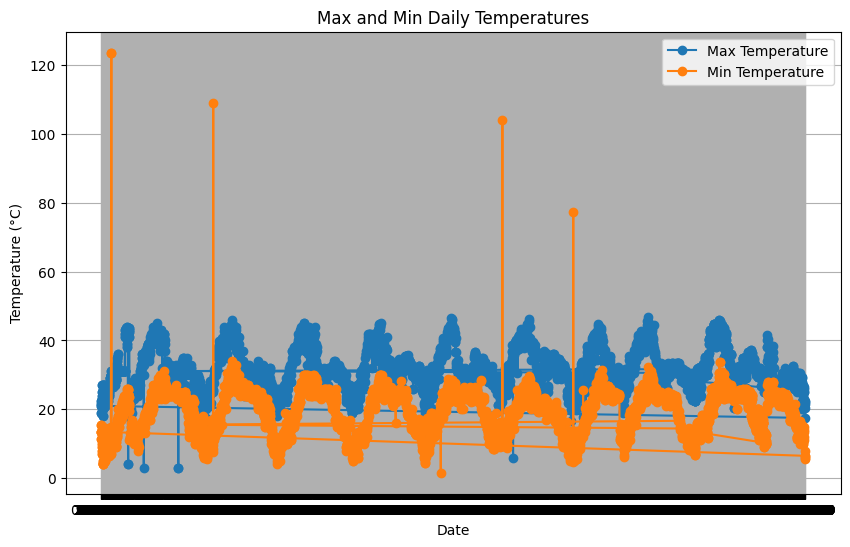

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(data['Date'], data['Max.'], marker='o', linestyle='-', label='Max Temperature')
plt.plot(data['Date'], data['Min.'], marker='o', linestyle='-', label='Min Temperature')

plt.title('Max and Min Daily Temperatures')
plt.xlabel('Date') # X-axis label
plt.ylabel('Temperature (°C)') # Y-axis label
plt.legend() # Show legend to identify lines
plt.grid(True) # grid for better readability

# 4. Show the plot
plt.show()

In [11]:
data['Date'] = pd.to_datetime(data['Date'] , format='%d.%m.%y')

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data = data.drop(columns=['Date'])


# Keep only rows where label is 0 or 1
data = data[data['Rainy Days '].isin([0, 1])]


In [12]:
data['Rainy Days '].unique()

array([0., 1.])

In [13]:
X = data.drop(columns=['Rainy Days ' , 'Rain'])
y = data['Rainy Days ']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
y_train.value_counts()

Rainy Days 
0.0    2606
1.0     598
Name: count, dtype: int64

In [15]:
y_test.value_counts()

Rainy Days 
0.0    651
1.0    150
Name: count, dtype: int64

In [16]:
2606/598

4.357859531772576

In [17]:
651/150

4.34

In [18]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss' , max_depth = 19, n_estimators = 100)  # disable label encoder warning
model.fit(X_train, y_train)

C:\Python Installation\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:03:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [19]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100)

Accuracy: 93.63295880149812


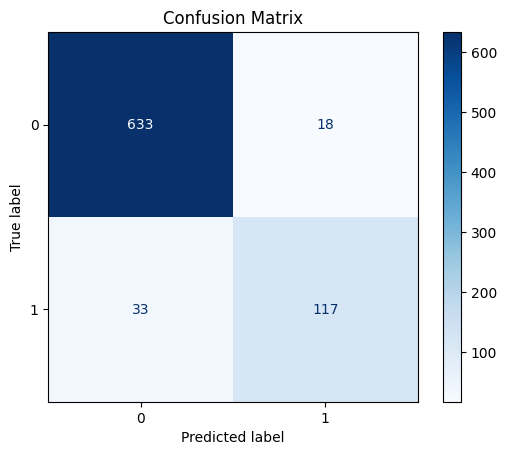

In [20]:
cm = confusion_matrix(y_test , y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Model Traning of XG Boost Regressor for Rainfall Amount

In [106]:
modelR = XGBRegressor(n_estimators = 2300 ,  gamma = 8  , device = 'cuda' ,max_dept = 8 , eta = 0.5 )

In [107]:
# selecting the days in which rain has occured , so we can predict the rain amount 
rain_days = data[data['Rainy Days '] == 1]
rain_days.shape

(748, 10)

In [108]:
X = rain_days.drop(columns=['Rain'])
y = rain_days['Rain']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=rain_days['Rainy Days '])

In [109]:
modelR.fit(X_train, y_train)
y_pred = modelR.predict(X_test)

C:\Python Installation\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "max_dept" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


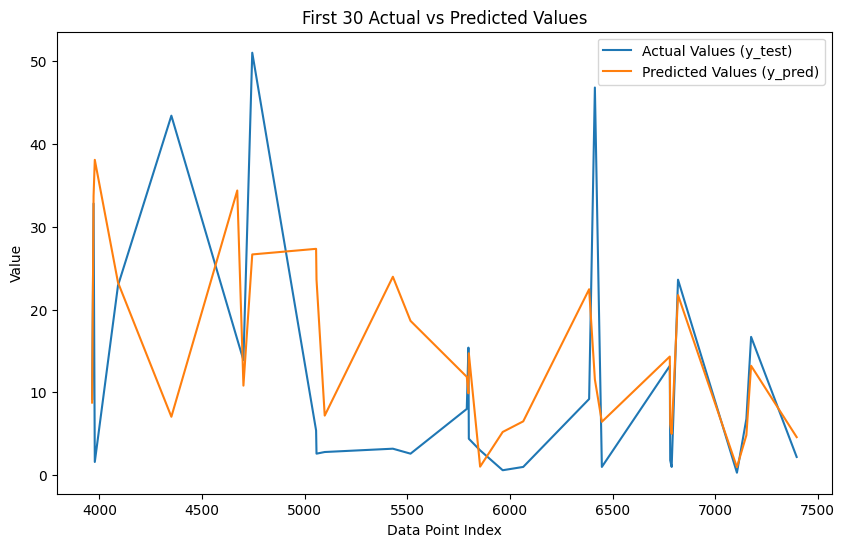

In [110]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Select only the first 30 rows
df_first_30 = df.head(30)
# plot
plt.figure(figsize=(10, 6))

sns.lineplot(x=df_first_30.index, y='y_test', data=df_first_30, label='Actual Values (y_test)')
sns.lineplot(x=df_first_30.index, y='y_pred', data=df_first_30, label='Predicted Values (y_pred)')

plt.title('First 30 Actual vs Predicted Values')
plt.xlabel('Data Point Index')
plt.ylabel('Value')

plt.legend()
plt.show()

Text(0, 0.5, 'Actual')

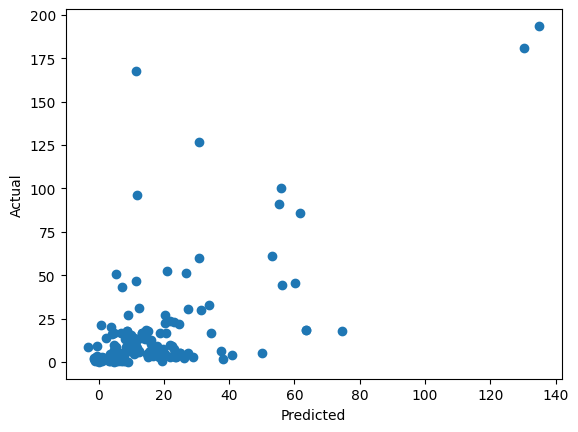

In [111]:
plt.scatter(y_pred , y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [112]:
# results time , here is the model performance

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)


print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)

# This are the results archived
# MAE: 13.080879848480224
# R2 Score: 0.4296928636777182
# RMSE: 23.416952182514603

MAE: 13.080879848480224
R2 Score: 0.4296928636777182
RMSE: 23.416952182514603
